# Week3 Assignments
**Please do the assignments using the `mlops_eng` environment.**

This week's assignments will give you some hands-on experience with Optuna (and Ray Tune). Similar to the tutorial of the first week, the [red wine dataset](https://archive.ics.uci.edu/dataset/186/wine+quality) will be used in this week's assignments. 

**Guidelines for submitting assignments**:
- For each assignment, a code skeleton is provided. Please put your solutions between the `### START CODE HERE` and `### END CODE HERE` code comments. Please **do not change any code other than those between the `### START CODE HERE` and `### END CODE HERE` comments**. Otherwise your notebook may not pass the tests used in grading.
- Some assignments also require you to answer questions (in text) or capture screenshots in order to earn points. Please put your text answers and screenshots in a single PDF file. For each answer and screenshot, please clearly indicate which assignment it corresponds to in your PDF file. Please include the PDF file in your submission.
- In Assignments 1 and 2, you'll be asked to save your Optuna Studies in an SQLite database "optuna.sqlite3" (the database will be created when you proceed with the assignments). Please also include this database in your submission (**do not change the file name, just keep it as "optuna.sqlite3"**). 

In [1]:
# import packages
import os
import pandas as pd
import numpy as np
import plotly
import platform
import time
import random
from typing import List, Dict
import logging
import warnings

import optuna
from optuna.integration.mlflow import MLflowCallback
from optuna.samplers import TPESampler
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
import xgboost as xgb
from ray import tune
from ray.tune.search.optuna import OptunaSearch

2025-11-21 15:59:43,332	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-11-21 15:59:44,772	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
import ray
ray.__version__

'2.9.3'

In [3]:
# Make sure you've installed the right version of lightgbm and xgboost
current_platform = platform.system()
print(f"Current platform: {current_platform}")
if current_platform == "Darwin" or current_platform == "Linux":
    if current_platform == "Darwin":  # macOS
        assert lgb.__version__.startswith("4.5.0"), f"Wrong version of lightgbm for platform: {current_platform}"
        assert xgb.__version__.startswith("2.0.3"), f"Wrong version of xgb for platform: {current_platform}"
    elif current_platform == "Linux": # Ubuntu
        assert lgb.__version__ == "4.0.0", f"Wrong version of lightgbm for platform: {current_platform}"
        assert xgb.__version__ == "2.0.3", f"Wrong version of xgboost for platform: {current_platform}"
    else:
        assert False, f"Unknown platform: {current_platform}"
else:
    assert False, f"Unexpected platform: {current_platform}"

Current platform: Linux


In [4]:
# This is just for the grading purpose
def is_being_graded():
    """
    Returns True if the notebook is being executed by the auto-grading tool.
    """
    env = os.environ.get("NBGRADER_EXECUTION")
    return env == "autograde" or env == "validate"


# Suppress loggings and warnings when grading the notebook
if is_being_graded():
    loggers = [logging.getLogger(name) for name in logging.root.manager.loggerDict]
    for logger in loggers:
        logger.setLevel(logging.ERROR)
    mlflow.utils.logging_utils.disable_logging()
    warnings.filterwarnings("ignore")

In [5]:
# Random seed for making the assignments reproducible
RANDOM_SEED = 42

# MLflow service URI
mlflow_tracking_uri = "http://mlflow-server.local"

# Configure MLflow 
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://mlflow-minio.local"
os.environ["AWS_ACCESS_KEY_ID"] = "minioadmin"
os.environ["AWS_SECRET_ACCESS_KEY"] = "minioadmin"

mlflow.set_tracking_uri(mlflow_tracking_uri)

In [6]:
# Prepare training and testing data
data = pd.read_csv("winequality-red.csv", delimiter=";")

X = data.drop("quality", axis=1)
y = data["quality"]

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

In [7]:
# An overview of the original dataset
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [8]:
print(f"The dimension of train_x is {train_x.shape}")
print(f"The dimension of train_y is {train_y.shape}")
print(f"The dimension of test_x is {test_x.shape}")
print(f"The dimension of test_y is {test_y.shape}")

The dimension of train_x is (1199, 11)
The dimension of train_y is (1199,)
The dimension of test_x is (400, 11)
The dimension of test_y is (400,)


## Assignment 1: The basic use of Optuna (2 points)
Your task is to use Optuna to find the optimal hyperparameter combination for the [LightGBM regression model](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html) used for predicting red wine quality. **Please use the sklearn API as you did in the first week's assignments.**

This assignment has the following requirements:

1) Define the objective function (`objective_func`). The target of the optimization is to minimize the MAE (mean absolute error) of the model when evaluating the model against the testing dataset. The hyperparameters to be tuned and their search ranges are shown below. Some of the hyperparameter values are fixed. The hyperparameter values should be sampled in a linear domain if not separately specified. In your objective function, please specify the hyperparameters in the same order as presented in the table.  

| Hyperparameter    | Explanation                                                                 | type    | range                                                                    |
|:-------------------|:-----------------------------------------------------------------------------|:---------|:--------------------------------------------------------------------------|
| n_estimators      | The number of decision trees.                                               | integer | 1000 (fixed value)                                                       |
| learning_rate     | The step size of the gradient descent. It controls how quickly the model fits and then overfits the training data.              | float   | [0.001, 0.1] (sampled from the logarithmic domain) |
| subsample         | The percentage of training samples to be used to train each tree. `subsample*100%` of the training samples will be randomly selected for training.        | float   | [0.05, 0.5]                                                              |
| subsample_freq    | Subsampling frequency. The subsampling will be performed again after `subsample_freq` trees have been trained.                                                     | integer | 1 (fixed value)                                                          |
| colsample_bytree  | The percentage of features to use when training each tree.                | float   | [0.05, 0.5]                                                              |
| min_child_samples | A leaf node should have `min_child_samples` data points to be further splitted. | integer | [20, 100]                                                                |
| num_leaves        | Max number of nodes in a single tree.                                       | integer | [2, 2^10]                                                                |
| random_state      | The seed for random number generation for reproducibility.                                   | integer | RANDOM_SEED (fixed value, RANDOM_SEED has been defined as a variable in a previous cell)                                                |

2) Define another function named `run_study` that creates and runs a study. Detailed requirements are listed below:
    - Use [TPESampler](https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.TPESampler.html) as the sampler for the hyperparameter sampling and use `RANDOM_SEED` as the seed of the sampler. 
    - The Optuna study should have a name specified by the `study_name` argument, use the objective function given as the `objective_func` argument and perform `n_trials` trials.
    - The study history should be persisted in a relational database specified by the `storage` argument so that the study can be loaded and analyzed later. 
    - The function should finally return the study.

Hints:
- [How to sample hyperparameter values in the logarithmic domain?](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial.suggest_float)
- [How to configure a study to use a specific sampler and persist study history in a specific database?](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.create_study.html#optuna-create-study)
- You'll probably see LightGBM throw a bunch of warnings of "No further splits with positive gain, best gain: -inf". This warning basically means LightGBM can't find a split that would improve the model's performance at a particular node. You can suppress these warning by setting `verbose=-1` when defining your model, e.g., `lgb.LGBMRegressor(verbose=-1, ...)`

**Notes**:
- When define the search space for the hyperparameters, please use the names given in the "Hyperparameter" column in the table above.
- Please **do not** use deprecated methods (e.g, suggest_uniform and suggest_loguniform) when define the search space. 

*More reading material: If you are interested, [the LightGBM documentation](https://lightgbm.readthedocs.io/en/latest/Parameters.html#core-parameters) explains the use of each hyperparameter in more details.*

In [9]:
# Define the objective function
def objective_func(trial):
    # TODO:
    # Define the hyperparameters to be tuned and their search ranges
    # Train a model using the sampled hyperparameters
    # Evaluate the model using the test dataset
    # Return the evaluation metric
    ### START CODE HERE
    params = {
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.05, 0.5),
        'subsample_freq': 1,
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.05, 0.5),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'num_leaves': trial.suggest_int('num_leaves', 2, 1024),
        'random_state': RANDOM_SEED,
        'verbose': -1 
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(train_x,train_y)
    pred = model.predict(test_x)
    mae = mean_absolute_error(test_y,pred)
    return mae
    ### END CODE HERE

def run_study(study_name: str, storage: str, objective_func: callable, n_trials: int) -> optuna.study.Study:
    """
    Create and run an Optuna study.
    Args:
        study_name: The name of the study.
        storage: The URI of the storage used to save the study history.
        objective_func: The objective function to be optimized.
        n_trials: The number of trials the study should perform.
    Returns:
        A Study object.
    """
    # Delete the study if it already exists
    if study_name in optuna.get_all_study_names(storage=storage):
        optuna.delete_study(study_name=study_name, storage=storage)

    # TODO: Create (and run) the study and record the history in the storage
    ### START CODE HERE
    sampler = TPESampler(seed = RANDOM_SEED)
    study = optuna.create_study(
        study_name=study_name,
        storage=storage,
        sampler=sampler,
        direction='minimize'
    )
    study.optimize(objective_func,n_trials=n_trials,show_progress_bar=False)

    return study
    ### END CODE HERE

In [10]:
# Assign "lgbm-wine-1" as the study_name to the Optuna study in the first assignment.
study_name_1 = "lgbm-wine-1"

# For this assignment, it is enough to use a simple sqlite3 database for persisting study history
storage = "sqlite:///optuna.sqlite3"

# When grading the notebook, the study will be loaded from the submitted database
study_1 = (
    run_study(
        study_name=study_name_1,
        storage=storage,
        objective_func=objective_func,
        n_trials=100,
    )
    if not is_being_graded()
    else optuna.load_study(study_name=study_name_1, storage=storage)
)

print("Best MAE", study_1.best_value)
print("Best params:", study_1.best_trial.params)

[I 2025-11-21 16:01:25,266] A new study created in RDB with name: lgbm-wine-1
[I 2025-11-21 16:01:26,097] Trial 0 finished with value: 0.48305757514051956 and parameters: {'learning_rate': 0.005611516415334507, 'subsample': 0.4778214378844623, 'colsample_bytree': 0.3793972738151323, 'min_child_samples': 68, 'num_leaves': 161}. Best is trial 0 with value: 0.48305757514051956.
[I 2025-11-21 16:01:26,452] Trial 1 finished with value: 0.6685091743119267 and parameters: {'learning_rate': 0.002051110418843397, 'subsample': 0.07613762547568977, 'colsample_bytree': 0.4397792655987208, 'min_child_samples': 68, 'num_leaves': 726}. Best is trial 0 with value: 0.48305757514051956.
[I 2025-11-21 16:01:27,229] Trial 2 finished with value: 0.5330860406894041 and parameters: {'learning_rate': 0.0010994335574766201, 'subsample': 0.48645943347289744, 'colsample_bytree': 0.4245991883601898, 'min_child_samples': 37, 'num_leaves': 188}. Best is trial 0 with value: 0.48305757514051956.
[I 2025-11-21 16:01:2

Best MAE 0.418099151103134
Best params: {'learning_rate': 0.02967900426626908, 'subsample': 0.46364572682407335, 'colsample_bytree': 0.4107961679403244, 'min_child_samples': 20, 'num_leaves': 181}


Example output:
```text
Best MAE 0.418099151103134
Best params: {'learning_rate': 0.02967900426626908, 'subsample': 0.46364572682407335, 'colsample_bytree': 0.4107961679403244, 'min_child_samples': 20, 'num_leaves': 181}
```

In [11]:
# Check the optimization results

# The required hyperparameters should be optimized
for param in ["learning_rate", "subsample", "colsample_bytree", "min_child_samples", "num_leaves"]:
    assert param in study_1.best_trial.params, f"Missing hyperparameter {param} from the objective function"

# The searching ranges should be correct
assert study_1.best_trial.distributions.get("learning_rate").log is True, "learning_rate should be searched in a log scale"
for param in ["learning_rate", "subsample", "colsample_bytree"]:
    assert isinstance(study_1.best_trial.distributions.get(param), optuna.distributions.FloatDistribution), f"{param} should be a float number"

for param in ["min_child_samples", "num_leaves"]:
    assert isinstance(study_1.best_trial.distributions.get(param), optuna.distributions.IntDistribution), f"{param} should be an integer"

# The study should perform 100 trials
assert len(study_1.trials) == 100, "Wrong number of trials"


In [ ]:
# Test the Optuna study results
assert study_1.best_value < 0.42, "Too large MAE"

## Assignment 2: Analyzing an Optuna study (2 points)
Optuna offers utility functions for visualizing the optimization process (i.e., study history). For example, it can plot the hyperparameter importance and the relationship between a hyperparameter and the objective. In this assignment, you need to analyze the study created in Assignment 1, adjust the search ranges of some hyperparameters to obtain better MAE. Detailed instructions will be provided later. 

In [13]:
import plotly.io as pio

# Configure Jupyter Notebook to render plotly figures drawn by Optuna
pio.renderers.default = "notebook"

### 2a) Hyperparameter importance
Implement a function `show_param_importances` that loads an Optuna study from a storage and return a plot showing importance of the hyperparameters in the study. Similar to the tutorial, use the [FanovaImportanceEvaluator](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.importance.FanovaImportanceEvaluator.html#optuna.importance.FanovaImportanceEvaluator) as the importance evaluator and set `RANDOM_STATE` as the seed for the evaluator for reproducibility. 

In [21]:
# Plot the hyperparameter importance
def show_param_importances(study_name: str, storage: str) -> plotly.graph_objs.Figure:
    """
    Plot the hyperparameter importance of a study.
    Args:
        study_name: The name of the study.
        storage: The URI of the storage used to save the study history.
    Returns:
        A plotly Figure object.
    """
    ### START CODE HERE
    study = optuna.load_study(study_name=study_name,storage=storage)
    importance_evaluator = optuna.importance.FanovaImportanceEvaluator()
    res = optuna.visualization.plot_param_importances(
        study,
        evaluator=importance_evaluator
    )
    return res
    ### END CODE HERE

param_importance_fig_wine = show_param_importances(study_name=study_name_1, storage=storage)
param_importance_fig_wine.show()

Next, put the names of the three most important hyperparameters in to a list named `important_hyperparams`

In [22]:
# TODO: important_hyperparams = ...
### START CODE HERE
important_hyperparams = ['learning_rate', 'num_leaves', 'colsample_bytree']
### END CODE HERE

In [23]:
assert isinstance(param_importance_fig_wine, plotly.graph_objs.Figure), "Incorrect importance plot"
assert len(important_hyperparams) == 3, "Incorrect number of important hyperparameters"


### 2b) The impact of hyperparameters
Complete the `plot_relationship_between_hyperparams_and_obj` function that loads an Optuna study from a storage and return a plot showing the relationships of the most three important hyperparameters and the objective in a slice plot. 

Hint: [How to plot the relationship between a hyperparameter and the objective?](https://optuna.readthedocs.io/en/stable/reference/visualization/generated/optuna.visualization.plot_slice.html)

In [25]:
def show_relationship_between_hyperparams_and_obj(study_name: str, storage: str, important_hyperparams: List[str]) -> plotly.graph_objs.Figure:
    """
    Plot the relationship between the hyperparameters and the objective function.
    Args:
        study_name: The name of the study.
        storage: The URI of the storage used to save the study history.
        important_hyperparams: A list of hyperparameters that are considered important.
    Returns:
        A plotly Figure object.
    """
    ### START CODE HERE
    study = optuna.load_study(study_name=study_name, storage=storage)
    fig = optuna.visualization.plot_slice(
        study, 
        params=important_hyperparams
    )
    return fig
    ### END CODE HERE

slice_fig_wine = show_relationship_between_hyperparams_and_obj(study_name=study_name_1, storage=storage, important_hyperparams=important_hyperparams)
slice_fig_wine.show()

In [26]:
assert isinstance(slice_fig_wine, plotly.graph_objs.Figure), "Incorrect slice plot"


### Question for Assignment 2b
Now you know the most three important hyperparameters that affect the objective value. Looking at the positions of the points in the slice plot, which area the points that resulted in better MAE are concentrated on? How would you adjust the search ranges of these three hyperparameters in the next study? Please put your answer in your PDF file. 

Three most important hyperparameters are usually: learning_rate, num_leaves, and colsample_bytree.we should narrow the search ranges of these most important hyperparameters to the optimal areas observed in the Slice Plot.

### 2c) An improved Optuna study
In this assignment, you have two tasks. First, complete another objective function `objective_func_2`, where you need to adjust the search ranges of the most three important hyperparameters to improve MAE (keep values/search ranges of other hyperparameters as the same as in Assignment 1).

Then complete the `run_improved_study` that starts and runs another Optuna study. Detailed requirements are listed below:
- Use [TPESampler](https://optuna.readthedocs.io/en/stable/reference/samplers/generated/optuna.samplers.TPESampler.html) as the sampler for the hyperparameter sampling and use `RANDOM_SEED` as the seed of the sampler. 
- The Optuna study should have a name specified by the `new_study_name` argument, use the objective function given as the `objective_func` argument and perform `n_trials` trials.
- The study history should be persisted in a relational database specified by the `storage` argument so that the study can be loaded and analyzed later. 
- You should start the study using the best hyperparameter combination of a previous study. The previous study should be loaded from the given storage using the study name given as the `prev_study_name` argument.
- The trials should be tracked in an MLflow experiment. 
- The function should finally return the study.

**Hints**: 
- Now you know the most three important hyperparameters that affect the objective value. Looking at the positions of the points in the slice plot, which areas the points that resulted in better MAE are concentrated on? 
- [How to log Optuna trials to MLflow?](https://optuna-integration.readthedocs.io/en/stable/reference/generated/optuna_integration.MLflowCallback.html)
- To start the new study using the best hyperparameter combination of the previous study, you can 1) load the previous study whose name is given as the `prev_study_name` argument, 2) retrieve the optimal hyperparameters combination of the previous study, 3) create a new study, 4) insert a trial with the best hyperparameter values of the previous study into the new study, and then start the optimization of the new study.


You may also find the following links helpful:
- [optuna.load_study](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.load_study.html)
- [study.best_params](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.Study.html#optuna.study.Study.best_params)
- [enqueue_trial](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.study.Study.html#optuna.study.Study.enqueue_trial). 

**Note**: If you want to delete all the trials in MLflow, don't delete the experiment, as deleting the experiment using the UI will not really delete the experiment in the PostgreSQL database used by MLflow, which will cause problems when recording trials under an experiment with the same name as the deleted experiment. Instead, you can keep the experiment and delete the trials, as shown in the image below. (If you feel like permanently deleting MLflow experiments from the PostgreSQL database, please check the `delete_from_mlflow.md` file in Week1 tutorials.

![](./images/mlflow-delete-trials.jpg)

<details>
    <summary>If callback and decorator are new to you...</summary>
    <p>Briefly speaking, both callbacks and decorators are used to modify or enhance the behavior of another function without modifying its original source code. A callback is a function that is typically provided as an argument to another function. A decorator typically takes another function as an argument. Feel free to google more about them. </p>
</details>

In [32]:
# Define the objective function
def improved_objective_func(trial):
    ### START CODE HERE
    params = {
        'n_estimators': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.08, log=True),
        'subsample': trial.suggest_float('subsample', 0.05, 0.5),
        'subsample_freq': 1,
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.9),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 150),
        'num_leaves': trial.suggest_int('num_leaves', 100, 800),
        'random_state': RANDOM_SEED,
        'verbose': -1 
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(train_x, train_y)
    
    predictions = model.predict(test_x)
    mae = mean_absolute_error(test_y, predictions)
    
    return mae
    ### END CODE HERE

def run_improved_study(prev_study_name: str, new_study_name: str, storage: str, objective_func: callable, n_trials: int) -> optuna.study.Study:
    """
    Create and run an Optuna study based on a previous study.
    Args:
        prev_study_name: The name of the previous study.
        new_study_name: The name of the new study.
        storage: The URI of the storage used to save the study history.
        objective_func: The objective function to be optimized.
        n_trials: The number of trials the study should perform.
    Returns:   
        An Optuna Study object.
    """
    # Some cleanup before starting the new study
    # Delete the study if it already exists
    if new_study_name in optuna.get_all_study_names(storage=storage):
        optuna.delete_study(study_name=new_study_name, storage=storage)

    mlflow_exp = mlflow.get_experiment_by_name(new_study_name)
    if mlflow_exp is not None:
        # Delete all old trials in the experiment
        for run in mlflow.search_runs(mlflow_exp.experiment_id, output_format="list"):
            mlflow.delete_run(run.info.run_id)
        
    ### START CODE HERE
    prev_study = optuna.load_study(study_name=prev_study_name,storage=storage)
    prev_study_best_params = prev_study.best_params

    sampler = TPESampler(seed=RANDOM_SEED)
    study = optuna.create_study(
        study_name = new_study_name,
        storage=storage,
        sampler = sampler,
        direction='minimize'
    )
    study.enqueue_trial(prev_study_best_params)
    mlflow_callback = MLflowCallback(
        tracking_uri = mlflow_tracking_uri,
        metric_name = "mae"
    )
    study.optimize(
        objective_func, 
        n_trials=n_trials, 
        callbacks=[mlflow_callback],
        show_progress_bar=False
    )
    return study
    ### END CODE HERE

In [33]:
# Name of the new study
new_study_name = "lgbm-wine-2"

study_2 = (
    run_improved_study(
        prev_study_name=study_name_1,
        new_study_name=new_study_name,
        storage=storage,
        objective_func=improved_objective_func,
        n_trials=20,
    )
    if not is_being_graded()
    else optuna.load_study(study_name=new_study_name, storage=storage)
)
print("Best MAE", study_2.best_value)
print("Best params:", study_2.best_trial.params)

[I 2025-11-21 17:33:39,963] A new study created in RDB with name: lgbm-wine-2
/tmp/ipykernel_4744/1070365039.py:59: ExperimentalWarning:

MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.

[I 2025-11-21 17:33:40,915] Trial 0 finished with value: 0.418099151103134 and parameters: {'learning_rate': 0.02967900426626908, 'subsample': 0.46364572682407335, 'colsample_bytree': 0.4107961679403244, 'min_child_samples': 20, 'num_leaves': 181}. Best is trial 0 with value: 0.418099151103134.
[I 2025-11-21 17:33:41,659] Trial 1 finished with value: 0.4751654415962778 and parameters: {'learning_rate': 0.014124115025060347, 'subsample': 0.4778214378844623, 'colsample_bytree': 0.7391963650868432, 'min_child_samples': 94, 'num_leaves': 209}. Best is trial 0 with value: 0.418099151103134.
[I 2025-11-21 17:33:42,200] Trial 2 finished with value: 0.6685091743119267 and parameters: {'learning_rate': 0.0077055940127295905, 'subsample': 0.07613762547568977, 'cols

Best MAE 0.4009620843773491
Best params: {'learning_rate': 0.06126895717482317, 'subsample': 0.4366417186922958, 'colsample_bytree': 0.4114910633255542, 'min_child_samples': 12, 'num_leaves': 494}


Example output:
```text
Best MAE 0.386448234091213
Best params: {'learning_rate': 0.020120960308154467, 'subsample': 0.9215993238868946, 'colsample_bytree': 0.825439643398257, 'min_child_samples': 10, 'num_leaves': 855}
```

In [34]:
# New MAE should be smaller than the previous one
assert study_2.best_value < study_1.best_value, "The new MAE should be smaller than the previous one"

# The new study should have 20 trials
assert len(study_2.trials) == 20, "Wrong number of trials"

# The first trial should be the same as the best trial of the previous study
assert study_2.trials[0].values[0] == study_1.best_value

# The ranges of at least one of the three most important hyperparameters should be changed
param_changed = False
for param in important_hyperparams:
    new_distribution = study_2.best_trial.distributions.get(param)
    old_distribution = study_1.best_trial.distributions.get(param)
    if new_distribution.low != old_distribution.low or new_distribution.high != old_distribution.high:
        param_changed = True
        break
assert param_changed, "The ranges of at least one of the three most important hyperparameters should be changed"


### Screenshot for Assignment 2c
Capture a screenshot of the trails of the "lgbm-wine-2" study in MLflow UI. Please include the metrics and parameters of each trial in your screenshot.

<details>
    <summary>Example:</summary>
    <img src="./images/trials-mlflow.png" width=1000/>
</details>


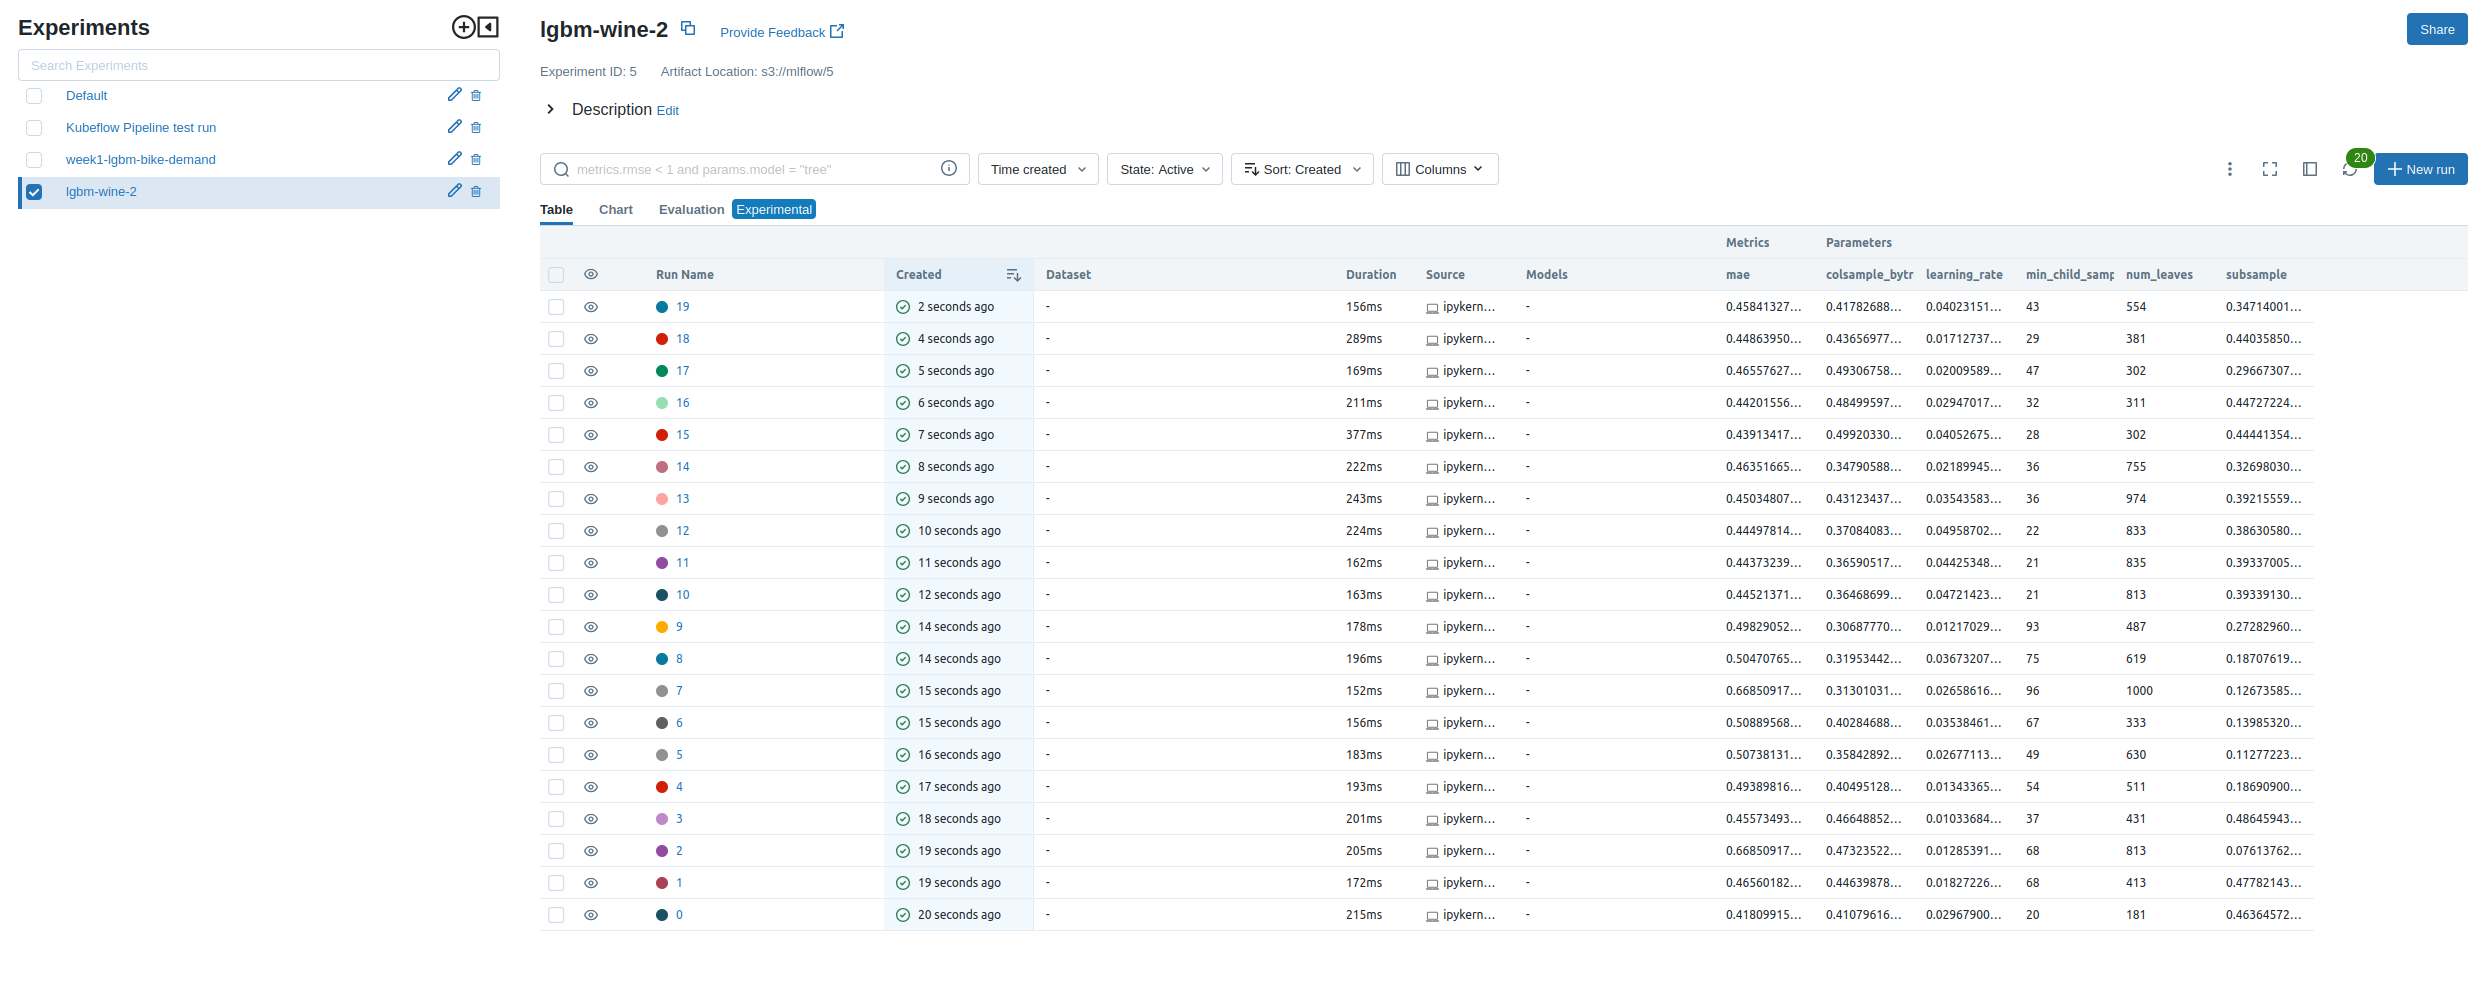

## Assignment 3: More about MLflow (2 points)
### 3a) Find the MLflow run with the best hyperparameter combination
In assignment 2c), you found the best hyperparameter combination for your model. Now, your task is to complete the `find_best_run_id` function. The function receives an MLflow Experiment name as the argument and returns the best MLflow Run ID that resulted in the best hyperparameter combination. In other words, this function should find the MLflow Run with the smallest MAE. 

You may find the following MLflow docs useful:
- [How to retrieve an MLflow Experiment given an Experiment name?](https://mlflow.org/docs/2.3.2/python_api/mlflow.html?highlight=get_experiment_by_name#mlflow.get_experiment_by_name)
- [How to search MLflow Runs inside an MLflow Experiment?](https://mlflow.org/docs/2.3.2/python_api/mlflow.html?highlight=search_runs#mlflow.search_runs)

In [35]:
def find_best_run_id(mlflow_experiment_name: str) -> str:
    """
    Find the ID of the MLflow run with the smallest MAE
    Args:
        mlflow_experiment_name: The name of the MLflow experiment where the run should be found
    Return:
        An MLflow run ID
    """
    ### START CODE HERE
    experiment = mlflow.get_experiment_by_name(mlflow_experiment_name)
    best = mlflow.search_runs(
        experiment_ids = [experiment.experiment_id],
        order_by=["metrics.mae ASC"],
        max_results = 1,
        output_format="list"
    )
    return best[0].info.run_id
    ### END CODE HERE

In [36]:
# From your MLflow UI you can check whether the printed MLflow Run ID really produced the smallest MAE
if not is_being_graded():
    best_run_id = find_best_run_id(mlflow_experiment_name=new_study_name)
    print(f"The best MLflow Run ID is: {best_run_id}")


The best MLflow Run ID is: 96ab8244d92243c59789376f3acbb905


### 3b) Train a model using the best hyperparameter combination
Your task is to train a model using the best hyperparameter combination found in Assignment 2c). You also need to upload and register the model to MLflow, the model needs to be associated with the MLflow Run where the optimal hyperparameter combination was found.

For example, suppose running the "lgbm-wine-2" study of Assignment 2 created an MLflow Run 14 where the best hyperparameter combination was found, the model created in this assignment needs to be associated with MLflow Run 14, as shown below:

<img src="./images/mlflow-best-run.png" width=1200/>

<img src="./images/mlflow-best-model.png" width=1200/>

Hints:
- You may find the following function helpful: [mlflow.start_run](https://mlflow.org/docs/2.3.2/python_api/mlflow.html#mlflow.start_run) (Pay attention to the use of the `run_id` parameter).
- It would probably be more convenient to retrieve the best hyperparameter combination using `optuna.load_study` rather than from the Mlflow Run. 

In [37]:
def train_optimized_model(study_name: str, storage: str, model_name: str):
    """
    Train a model with the best hyperparameters found by Optuna.
    Args:
        study_name: The name of the Optuna study where the best hyperparameters have been found. This is also the name of the MLflow experiment.
        storage: The URI of the storage used to save the study history.
        model_name: The name of the registered MLflow model.
    """
    ### START CODE HERE
    study = optuna.load_study(study_name=study_name, storage=storage)
    best_params = study.best_params
    params = {
        'n_estimators': 1000,
        'subsample_freq': 1,
        'random_state': RANDOM_SEED,
        'verbose': -1,
        **best_params # Overwrites any common keys if present, but here it's fine
    }
    best_run_id = find_best_run_id(mlflow_experiment_name=study_name)
    with mlflow.start_run(run_id = best_run_id):
        optimized_model = lgb.LGBMRegressor(**params)
        optimized_model.fit(train_x,train_y)
        predictions = optimized_model.predict(test_x)
        mae = mean_absolute_error(test_y,predictions)

        mlflow.lightgbm.log_model(
            lgb_model = optimized_model,
            artifact_path="model",
            registered_model_name=model_name
        )
    ### END CODE HERE

In [38]:
# From your MLflow UI you can make sure that the registered model is associated with the 
if not is_being_graded():
    train_optimized_model(study_name=new_study_name, storage=storage, model_name="optuna-lgbm-wine")


Successfully registered model 'optuna-lgbm-wine'.
2025/11/21 20:42:21 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: optuna-lgbm-wine, version 1
Created version '1' of model 'optuna-lgbm-wine'.


### Screenshots for Assignment 3b)
Submit the screenshots of the registered model version info and the corresponding MLflow run. You can take the images in the assignment instructions above as an example. 


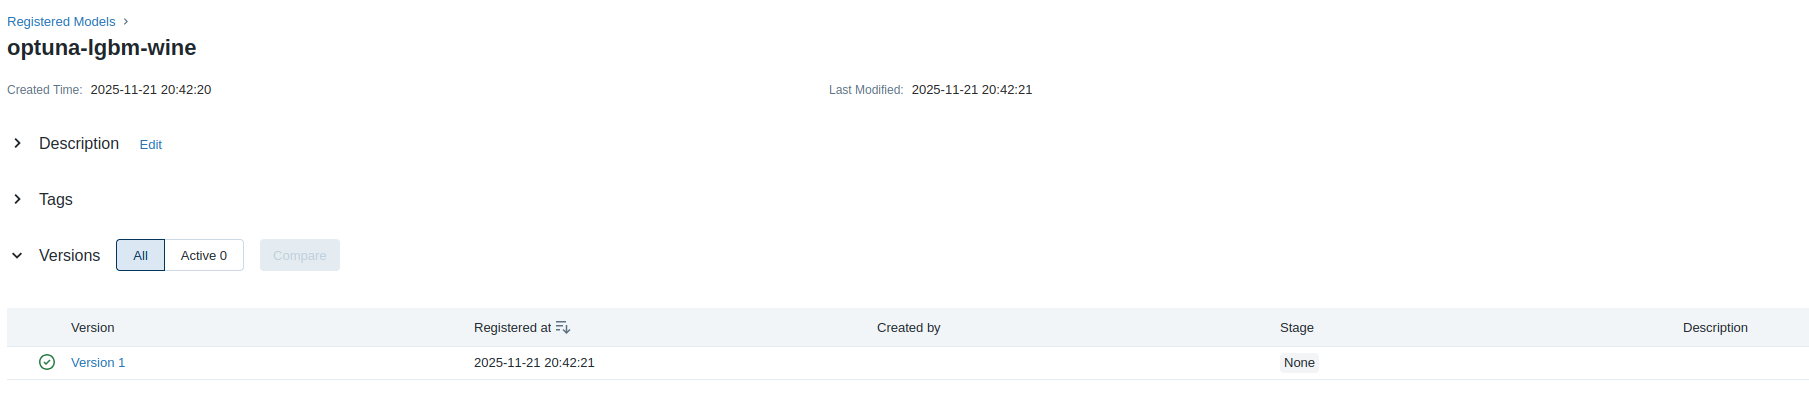

## Assignment 4: Conditional search space with Optuna (2 points)
Complete the objective function `objective_func_multimodel`. The target is to optimize the hyperparameters of a LightGBM and an [XGBoost](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBRegressor) regression model for the red wine quality prediction use case and see which model type is better in the use case. Similar to the previous assignments, the objective is also a smaller MAE. The hyperparameters to be tuned and their search ranges are given below. Use TPESampler with `RANDOM_SEED` as the random seed.

**LightGBM**: 
| Hyperparameter    | Explanation                                                                 | type    | range                                                                    |
|:-------------------|:-----------------------------------------------------------------------------|:---------|:--------------------------------------------------------------------------|
| n_estimators      | The number of decision trees.                                               | integer | 1000 (fixed value)                                                       |
| learning_rate     | The step size of the gradient descent. It controls how quickly the model fits and then overfits the training data.              | float   | [0.001, 0.1] (sampled from the logarithmic domain) |
| subsample         | The percentage of training samples to be used to train each tree. `subsample*100%` of the training samples will be randomly selected for training.        | float   | [0.05, 1.0]                                                              |
| subsample_freq    | Subsampling frequency. The subsampling will be performed again after `subsample_freq` trees have been trained.                                                     | integer | 1 (fixed value)                                                          |
| colsample_bytree  | The percentage of features to use when training each tree.                | float   | [0.05, 1.0]                                                              |
| min_child_samples | A leaf node should have at least `min_child_samples` data points to be further splitted. | integer | [1, 100]                                                                |
| num_leaves        | Max number of nodes in a single tree.                                       | integer | [2, 2^10]                                                                |
| random_state      | The seed for random number generation for reproducibility.                                   | integer | RANDOM_SEED (fixed value) 

**XGBoost**
| Hyperparameter    | Explanation                                                                 | type    | range                                                                    |
|:-------------------|:-----------------------------------------------------------------------------|:---------|:--------------------------------------------------------------------------|
| n_estimators      | Same as LightGBM.                                               | integer | 1000 (fixed value)                                                       |
| learning_rate     | Same as LightGBM.             | float   | [0.001, 0.1] (sampled from the logarithmic domain) |
| subsample         | Same as LightGBM.            | float   | [0.05, 1.0]                                                              |                                         
| colsample_bytree  | Same as LightGBM.                | float   | [0.05, 1.0]                                                              |
| min_child_weight | Minimum sum of instance weight needed for a leaf mode to be further splitted (similar to min_child_samples in LightGBN). | integer | [1, 100]                                                                |
| max_depth        | Max depth of a single tree                                       | integer | [1, 10]                                                                |
| random_state      | Same as LightGBM.                                   | integer | RANDOM_SEED (fixed value)    

**Notes**: 
- When specifying the search ranges for the model type, please use **"model_type"** as the parameter name that indicates the model type and `["lgbm", "xgb"]` as the value candidates.
- Some of the hyperparameters to be optimized used by the LightGBM and XGBoost models share the same names. In the assignment, these hyperparameters are `learning_rate, subsample, colsample_bytree`. You need to give these hyperparameters a unique name when defining their search ranges using `trial.suggest_*` so that Optuna can properly optimize the correct hyperparameters for each different model. Please rename the hyperparameters as `<hyperparameter-name>_lgbm` for the LightGBM model and `<hyperparameter-name>_xgb` for the XGBoost model, such as `learning_rate_lgbm` and `learning_rate_xgb`. 

In [39]:
def objective_func_multimodel(trial):
    ### START CODE HERE
    model_type = trial.suggest_categorical('model_type', ['lgbm', 'xgb'])
    
    if model_type == 'lgbm':
        params = {
            'n_estimators': 1000,
            'random_state': RANDOM_SEED,
            'learning_rate': trial.suggest_float('learning_rate_lgbm', 0.001, 0.1, log=True),
            'subsample': trial.suggest_float('subsample_lgbm', 0.05, 1.0),
            'subsample_freq': 1,
            'colsample_bytree': trial.suggest_float('colsample_bytree_lgbm', 0.05, 1.0),
            'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
            'num_leaves': trial.suggest_int('num_leaves', 2, 1024),
            'verbose': -1 
        }
        model = lgb.LGBMRegressor(**params)
        model.fit(train_x, train_y)
    elif model_type == 'xgb':
        params = {
            'n_estimators': 1000,
            'random_state': RANDOM_SEED,
            'learning_rate': trial.suggest_float('learning_rate_xgb', 0.001, 0.1, log=True),
            'subsample': trial.suggest_float('subsample_xgb', 0.05, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree_xgb', 0.05, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 100),
            'max_depth': trial.suggest_int('max_depth', 1, 10),
            'objective': 'reg:squarederror'
        }
        model = xgb.XGBRegressor(**params)
        model.fit(train_x, train_y)

    pred = model.predict(test_x)
    mae = mean_absolute_error(test_y, pred)
    
    return mae
    ### END CODE HERE


In [40]:
multimodel_study_name = "multimodel-wine"
multimodel_study = run_study(
    study_name=multimodel_study_name,
    storage=None,
    objective_func=objective_func_multimodel,
    n_trials=10,
)

print("Best MAE", multimodel_study.best_value)
print("Best params:", multimodel_study.best_trial.params)


[I 2025-11-21 20:51:24,024] A new study created in memory with name: multimodel-wine
[I 2025-11-21 20:51:24,587] Trial 0 finished with value: 0.49022297143936155 and parameters: {'model_type': 'xgb', 'learning_rate_xgb': 0.029106359131330698, 'subsample_xgb': 0.6187255599871848, 'colsample_bytree_xgb': 0.19821770842031466, 'min_child_weight': 16, 'max_depth': 1}. Best is trial 0 with value: 0.49022297143936155.
[I 2025-11-21 20:51:24,680] Trial 1 finished with value: 0.6685091743119267 and parameters: {'model_type': 'lgbm', 'learning_rate_lgbm': 0.02607024758370768, 'subsample_lgbm': 0.06955526958101232, 'colsample_bytree_lgbm': 0.9714143595538947, 'min_child_samples': 84, 'num_leaves': 219}. Best is trial 0 with value: 0.49022297143936155.
[I 2025-11-21 20:51:25,362] Trial 2 finished with value: 0.46709711909294127 and parameters: {'model_type': 'xgb', 'learning_rate_xgb': 0.0040596116104843075, 'subsample_xgb': 0.548518610050626, 'colsample_bytree_xgb': 0.46034776771000996, 'min_chil

Best MAE 0.42899067751612513
Best params: {'model_type': 'lgbm', 'learning_rate_lgbm': 0.012172847081122434, 'subsample_lgbm': 0.18387801372602453, 'colsample_bytree_lgbm': 0.8120871317163377, 'min_child_samples': 8, 'num_leaves': 1011}


Example output:
```text
Best MAE 0.42899067751612513
Best params: {'model_type': 'lgbm', 'learning_rate_lgbm': 0.012172847081122434, 'subsample_lgbm': 0.18387801372602453, 'colsample_bytree_lgbm': 0.8120871317163377, 'min_child_samples': 8, 'num_leaves': 1011}
```

## Assignment 5: Ensemble averaging (2 points)
Complete the objective function `objective_func_ensemble`. The purpose is to Optuna to find the optimal weight combination to combine the predictions of an Sklearn's RandomForest, a XGBoost, and a LightGBM model to obtain better predictions for the red wine quality us case. Detailed instructions are given below. 

Before going to the assignment, first train three models for the red wine quality use case using Sklearn's RandomForest, XGBoost, and LightGBM and evaluate MAE of each model. For simplicity, the default configurations of the hyperparameters are used except for "random_state" which is set as `RANDOM_SEED` as in the previous assignments. 

In [41]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=RANDOM_SEED)
xgb_model = xgb.XGBRegressor(random_state=RANDOM_SEED)
lgbm_model = lgb.LGBMRegressor(random_state=RANDOM_SEED, verbose=-1)

model_names = ["rf_model", "xgb_model", "lgbm_model"]

for name in model_names:
    model = eval(name)
    model.fit(train_x, train_y)
    predictions = model.predict(test_x)
    print(f"{name}: {mean_absolute_error(test_y, predictions)}")


rf_model: 0.42284999999999995
xgb_model: 0.42444213390350344
lgbm_model: 0.43465539993381924


You can see the best performing model is the random forest one, with an MAE of 0.4228.

Now, it is time to combine the predictions of these models to improve the final prediction. In this assignment, your task is to complete the objective function `objective_func_ensemble`. The target is to find the best weight combination for the three models that have been trained in the cell above to obtain smaller MAE. Use 3 as the [step of discretization](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html#optuna.trial.Trial.suggest_int) when searching weight for each model. The search range of the weight should be [1, 100]. Use TPESampler (with `RANDOM_SEED` as the seed) in the study.

**Note**: Please use "rf_model", "xgb_model", and "lgbm_model" as the names of the parameters that specify the weights of the random forest, XGBoost, and LightGBM models, respectively. E.g., 
```python
study = run_study(study_name="ensemble-wine", storage=None, objective_func=objective_func_ensemble, n_trials=10)
print(study.best_trial.params)
# Example_output:
# {'rf_model': 46, 'xgb_model': 79, 'lgbm_model': 19}
```

In [42]:
all_predictions = {name: (eval(name)).predict(test_x) for name in model_names}

# Define the objective function
def objective_func_ensemble(trial):
    ### START CODE HERE
    rf_weight = trial.suggest_int("rf_model", 1, 100, step=3)
    xgb_weight = trial.suggest_int("xgb_model", 1, 100, step=3)
    lgbm_weight = trial.suggest_int("lgbm_model", 1, 100, step=3)

    weight = rf_weight + xgb_weight + lgbm_weight

    predictions = np.zeros_like(test_y,dtype=float)

    predictions += rf_weight * all_predictions['rf_model']
    predictions += xgb_weight * all_predictions['xgb_model']
    predictions += lgbm_weight * all_predictions['lgbm_model']

    predictions /= weight
    mae = mean_absolute_error(test_y,predictions)
    return mae
    ### END CODE HERE

In [43]:
study_ensemble = run_study(study_name="ensemble-wine", storage=None, objective_func=objective_func_ensemble, n_trials=10)

print("Best MAE", study_ensemble.best_value)
print("Best params:", study_ensemble.best_trial.params)

[I 2025-11-21 21:11:19,219] A new study created in memory with name: ensemble-wine
[I 2025-11-21 21:11:19,235] Trial 0 finished with value: 0.41652429555863707 and parameters: {'rf_model': 37, 'xgb_model': 97, 'lgbm_model': 73}. Best is trial 0 with value: 0.41652429555863707.
[I 2025-11-21 21:11:19,241] Trial 1 finished with value: 0.4167632784253199 and parameters: {'rf_model': 61, 'xgb_model': 16, 'lgbm_model': 16}. Best is trial 0 with value: 0.41652429555863707.
[I 2025-11-21 21:11:19,251] Trial 2 finished with value: 0.41925149465179073 and parameters: {'rf_model': 4, 'xgb_model': 88, 'lgbm_model': 61}. Best is trial 0 with value: 0.41652429555863707.
[I 2025-11-21 21:11:19,263] Trial 3 finished with value: 0.41989033789428 and parameters: {'rf_model': 73, 'xgb_model': 1, 'lgbm_model': 97}. Best is trial 0 with value: 0.41652429555863707.
[I 2025-11-21 21:11:19,273] Trial 4 finished with value: 0.41691708988720605 and parameters: {'rf_model': 85, 'xgb_model': 22, 'lgbm_model': 19

Best MAE 0.41523636202081865
Best params: {'rf_model': 46, 'xgb_model': 79, 'lgbm_model': 19}


Example output:
```text
Best MAE 0.41523636202081865
Best params: {'rf_model': 46, 'xgb_model': 79, 'lgbm_model': 19}
```

In [44]:
assert (
    study_ensemble.best_value < 0.4228
), "The MAE should be smaller than 0.4228 (the MAE of the best single model)"

assert set(study_ensemble.best_trial.params.keys()) == set(["rf_model", "xgb_model", "lgbm_model"]), "Incorret parameter names"


## Assignment 6: Scale up Optuna using Ray Tune
In this assignment, you need to parallelize the Optuna hyperparameter optimization process using Ray Tune. Specifically, you will do this in three steps:
1. Complete the `trainable` function to define a Trainable. You need to specify the model, the model training process, and the metric to be optimized. Similar to Assignment 1, the model is an LightGBM regressor, and the metric to be optimized is MAE. 
1. Complete the `create_search_algo` function to define search spaces and the search algorithm. Use [OptunaSearch](https://docs.ray.io/en/latest/tune/api/doc/ray.tune.search.optuna.OptunaSearch.html) here. The search spaces should be the same as Assignment 1. Use the TPESampler as you did in Assignment 1.
1. Complete the `create_ray_tuner` function to define a Tuner that launches hyperparameter optimization trials. This function receives a Boolean argument named `parallel`. If `parallel` is set to False, the Tuner should perform the hyperparameter optimization trials one by one. Otherwise, the Tuner should use all available CPUs on your machine to run the trials concurrently. You'll find the details of the arguments passed to the function in the function docs. 

**Notes**:
- Remember to specify the random seed (`RANDOM_SEED`) for your model and sampler.
- When define the Trainable, please use **"mae"** as the metric name when report the metric to the Tuner. 
- The actual number of the concurrent jobs doesn't matter (as long as it's larger than 1) as it depends on the number of CPUs available on your machine. 

In [60]:
def trainable(config: Dict):
    """
    Defines a model using the given configuration, trains it, and report the metric.
    Args:
        config: A dictionary containing the hyperparameters to be tuned
    """
    ### START CODE HERE
    params = {
        'n_estimators': 1000,
        'learning_rate': config['learning_rate'],
        'subsample': config['subsample'],
        'subsample_freq': 1,
        'colsample_bytree': config['colsample_bytree'],
        'min_child_samples': config['min_child_samples'],
        'num_leaves': config['num_leaves'],
        'random_state': RANDOM_SEED,
        'verbose': -1 
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(train_x, train_y)
    predictions = model.predict(test_x)
    mae = mean_absolute_error(test_y, predictions)
    tune.report(mae=mae)
    ### END CODE HERE


def create_search_algo() -> OptunaSearch:
    """
    Create an Optuna search algorithm.
    """
    ### START CODE HERE
    sampler = TPESampler(seed=RANDOM_SEED) 
    
    algo = OptunaSearch(
        sampler=sampler,
        metric="mae",
        mode="min",
    )
    return algo
    ### END CODE HERE


def create_ray_tuner(
    trainable: callable, algo: OptunaSearch, n_trials: int, parallel: bool = False
) -> tune.Tuner:
    """
    Create a Ray Tune Tuner
    Args:
        trainable: The Trainable that specifies the objective.
        algo: The search algorithm.
        n_trials: The number of trials.
        parallel: Whether to run the trials in parallel.
    """
    ### START CODE HERE
    ray.init(ignore_reinit_error=True)

    search_space = {
        'learning_rate': tune.loguniform(0.001, 0.1),
        'subsample': tune.uniform(0.05, 0.5),
        'colsample_bytree': tune.uniform(0.05, 0.5),
        'min_child_samples': tune.randint(20, 101),
        'num_leaves': tune.randint(2, 1025),
    }

    # parallel=False → 串行：一次只能跑 1 个 trial
    # parallel=True  → 并行：使用所有 CPU
    max_concurrent = 1 if not parallel else None

    tune_config = tune.TuneConfig(
        num_samples=n_trials,
        search_alg=algo,
        metric="mae",
        mode="min",
        max_concurrent_trials=max_concurrent,
    )

    tuner = tune.Tuner(
        trainable,
        param_space=search_space,
        tune_config=tune_config,
    )

    return tuner
    ### END CODE HERE


In [61]:
# When the Tuner is running trials sequentially, the best hyperparameters should be the same as the ones found by the Optuna study in the first assignment
tuner = create_ray_tuner(trainable=trainable, algo=create_search_algo(), n_trials=10, parallel=False)
results = tuner.fit()
original_optuna_study = run_study(study_name="original", storage=None, objective_func=objective_func, n_trials=10)
assert results.get_best_result(metric="mae", mode="min").metrics.get("mae") == original_optuna_study.best_value, "Incorrect best hyperparameters"

2025-11-21 21:51:20,187	ERROR tune_controller.py:1374 -- Trial task failed for trial trainable_b3f956ea
Traceback (most recent call last):
  File "/home/user/anaconda3/envs/mlops/lib/python3.11/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/home/user/anaconda3/envs/mlops/lib/python3.11/site-packages/ray/_private/auto_init_hook.py", line 22, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/user/anaconda3/envs/mlops/lib/python3.11/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/user/anaconda3/envs/mlops/lib/python3.11/site-packages/ray/_private/worker.py", line 2624, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(DeprecationWarning): ray::ImplicitFunc.train() (pid=23360, ip=10.0.2.15, actor_id=4482e0b3a71bb7

RuntimeError: No best trial found for the given metric: mae. This means that no trial has reported this metric, or all values reported for this metric are NaN. To not ignore NaN values, you can set the `filter_nan_and_inf` arg to False.

In [62]:
# Mock a slow training process
def slow_trainable(config):
    time.sleep(10)
    return ({"mae": random.random()})

tuner_parallelized = create_ray_tuner(trainable=slow_trainable, algo=create_search_algo(), n_trials=5, parallel=True)
start_time = time.time()
results = tuner_parallelized.fit()
end_time = time.time()

assert end_time - start_time < 50, "It should take less than 50s to complete the optimization in the parallel mode"


2025-11-21 22:03:50,491	INFO tune.py:1042 -- Total run time: 36.98 seconds (36.88 seconds for the tuning loop).


## Wrap-up
Please include the following files in your submission:
- This Jupyter notebook (`week3_assignments.ipynb`)
- The "optuna.sqlite3" database file
- The PDF file containing your answers for Assignment 2b and screenshots for Assignments 2c and 3b

**N.B.** Before making your submission, please check that your notebook and database files are named **exactly** as specified here.